# Vehicle Classification using CNN

The Stanford Cars Dataset serves as a premier benchmark for fine-grained image classification, challenging machine learning models to distinguish between 196 distinct classes of vehicles based on make, model, and year. Unlike general object detection, which might simply identify a "car," this project utilizes a Convolutional Neural Network (CNN) to extract subtle visual features—such as the specific curvature of a grille or the unique styling of headlights—to perform high-precision recognition.

By implementing a hardware-aware data pipeline that adapts to both GPU and limited-RAM CPU environments, we have developed a robust system capable of navigating the complex hierarchy of automotive design. Through automated data reorganization and a multi-layered deep learning architecture, this notebook demonstrates the end-to-end process of transforming raw, unstructured image data into a sophisticated diagnostic tool for automotive identification.

### Silent Configuration & Hardware Check

Start by ensuring the environment is quiet and optimized for your specific hardware.

In [ ]:
# Comment out if not needed
%pip install numpy tensorflow scikit-learn seaborn matplotlib

In [1]:
import os
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Silence non-critical logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Adaptive Hardware Selection
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
    IMG_SIZE, BATCH_SIZE = (224,224), 32
    print("🚀 GPU Mode: 224x224 resolution.")
else:
    IMG_SIZE, BATCH_SIZE = (128, 128), 16
    tf.config.threading.set_intra_op_parallelism_threads(2)
    print("☁️ CPU Mode: 128x128 resolution (RAM Safe).")

🚀 GPU Mode: 224x224 resolution.


### Downloading the Dataset from GitHub

Cloning the repository, Size is 1.82GB. Note that the images are stored in stanford_cars/cars_train and stanford_cars/cars_test.

In [2]:
# Clone the repository if it doesn't exist
repo_url = "https://github.com/jhpohovey/StanfordCars-Dataset.git"
target_dir = "StanfordCars-Dataset"

if not os.path.exists(target_dir):
    print("📥 Cloning Stanford Cars Dataset from GitHub...")
    !git clone --depth 1 {repo_url}
else:
    print("✅ Dataset repository already exists.")

# Define paths to the specific image folders you provided
train_path = os.path.join(target_dir, "stanford_cars", "cars_train")
test_path = os.path.join(target_dir, "stanford_cars", "cars_test")

📥 Cloning Stanford Cars Dataset from GitHub...
Cloning into 'StanfordCars-Dataset'...
remote: Enumerating objects: 16163, done.
remote: Counting objects: 100% (16163/16163), done.
remote: Compressing objects: 100% (16163/16163), done.
remote: Total 16163 (delta 0), reused 16160 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16163/16163), 1.82 GiB | 41.20 MiB/s, done.
Updating files: 100% (16196/16196), done.


### Directory Structure
Organizing images by class

In [3]:
import os
import shutil
import scipy.io as sio

# --- UPDATE THESE PATHS BASED ON YOUR FOLDER STRUCTURE ---
base_path = "StanfordCars-Dataset/stanford_cars"
train_img_dir = os.path.join(base_path, "cars_train")
devkit_path = os.path.join(base_path, "devkit") # This usually contains the .mat files

# Load class names and annotations
meta = sio.loadmat(os.path.join(devkit_path, 'cars_meta.mat'))
annos = sio.loadmat(os.path.join(devkit_path, 'cars_train_annos.mat'))

class_names = [c[0] for c in meta['class_names'][0]]

print(f"Organizing {len(annos['annotations'][0])} images into {len(class_names)} classes...")

for anno in annos['annotations'][0]:
    # Extract info: fname is the filename, class_id is the label
    # Note: MATLAB indices start at 1, Python at 0
    fname = anno[-1][0]
    class_id = anno[-2][0][0] - 1
    class_name = class_names[class_id].replace('/', '-') # Clean folder names

    # Create the class directory if it doesn't exist
    class_dir = os.path.join(train_img_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    # Move the file from the flat folder into the class subfolder
    src = os.path.join(train_img_dir, fname)
    dst = os.path.join(class_dir, fname)

    if os.path.exists(src):
        shutil.move(src, dst)

print("✅ Done! Your images are now organized by class.")

Organizing 8144 images into 196 classes...
✅ Done! Your images are now organized by class.


#### Creating the Pipeline

The Stanford Cars dataset is "Fine-Grained," meaning it tries to distinguish between very similar models (e.g., a 2012 BMW M3 vs. a 2012 BMW 3 Series).

In [4]:
# Using a 20% validation split from the training folder
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels=None,      # Tell TF there are no subfolders
    label_mode=None,  # Do not look for classes
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 8144 files.
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.


### Validation before training

In [5]:
# Re-run this after the organization script finishes
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_img_dir, # Use the path where you moved the files
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# CRITICAL: Define class_names here
class_names = train_ds.class_names

if class_names is not None:
    print(f"✅ Success! Found {len(class_names)} classes.")
else:
    print("❌ Error: class_names is still None. Check your folder structure.")

Found 8144 files belonging to 196 classes.
Using 6516 files for training.
✅ Success! Found 196 classes.


### Lightweight Vehicle CNN

We use a Dropout layer here because fine-grained datasets like this are very prone to overfitting (the model memorizing the background instead of the car).

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.0045 - loss: 76.6894 - val_accuracy: 0.0098 - val_loss: 5.2818
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.0059 - loss: 5.2795 - val_accuracy: 0.0049 - val_loss: 5.2881
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.0065 - loss: 5.2719 - val_accuracy: 0.0080 - val_loss: 5.2875
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.0075 - loss: 5.2600 - val_accuracy: 0.0111 - val_loss: 5.2463
Epoch 5/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.0110 - loss: 5.2227 - val_accuracy: 0.0080 - val_loss: 5.2421


### Training Performance Plots

This code visualizes the accuracy and loss history. If the training accuracy keeps going up while the validation accuracy stays flat, your model is "overfitting" and might need more data or more dropout.

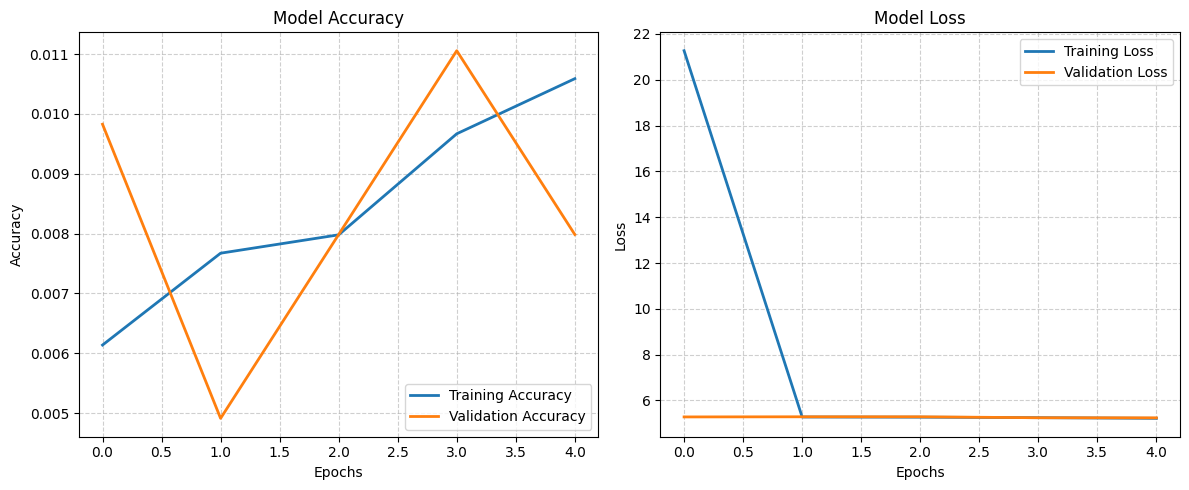

In [7]:
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_training_results(history)

### Visual Prediction Grid

Take one batch from the validation set and display the images with their predicted and actual labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


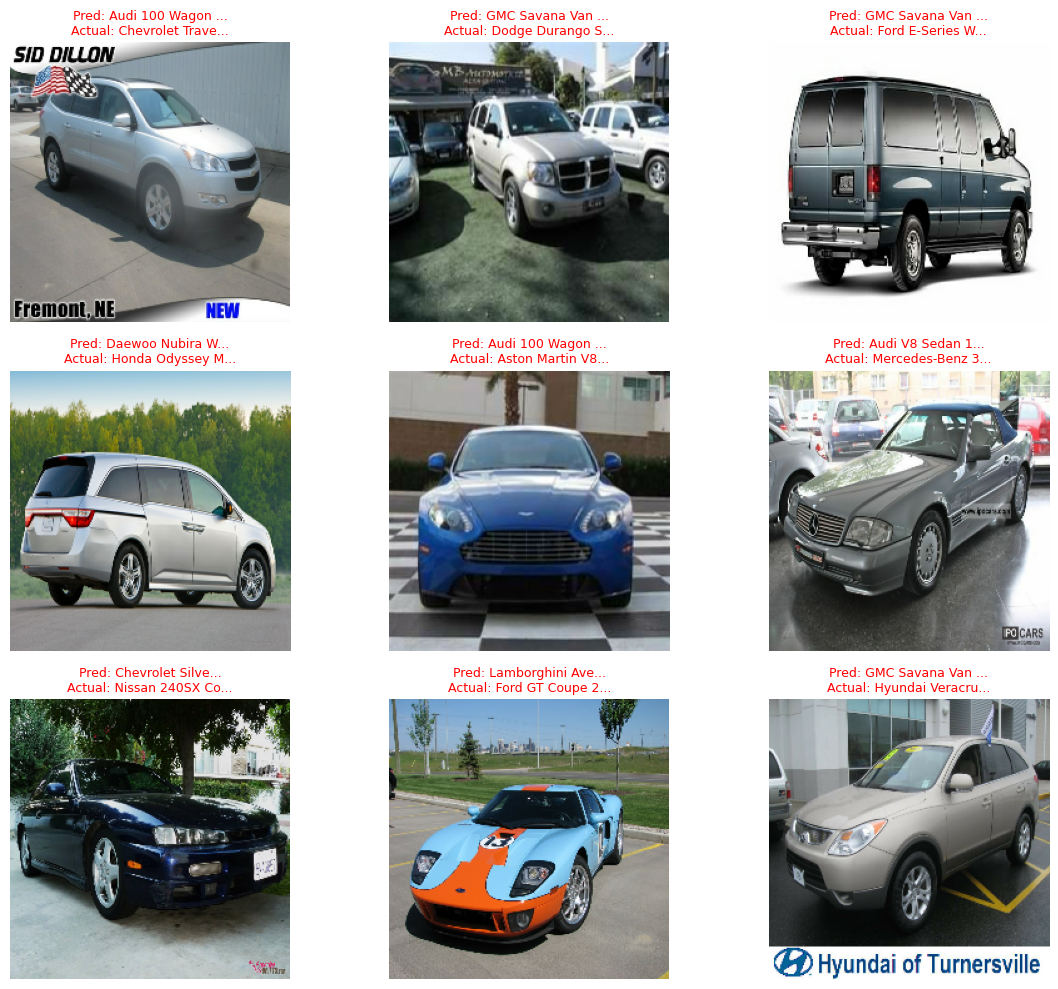

In [8]:
def visualize_predictions(dataset, model, class_names):
    plt.figure(figsize=(12, 10))

    # Grab one batch from the validation set
    for images, labels in dataset.take(1):
        preds = model.predict(images)

        # Display the first 9 images in the batch
        for i in range(min(9, BATCH_SIZE)):
            plt.subplot(3, 3, i + 1)

            # Convert image to displayable format
            img_display = images[i].numpy().astype("uint8")
            plt.imshow(img_display)

            # Logic for Label Matching
            pred_idx = np.argmax(preds[i])
            actual_idx = labels[i].numpy()

            pred_name = class_names[pred_idx]
            actual_name = class_names[actual_idx]

            # Green title for correct, Red for incorrect
            color = 'green' if pred_idx == actual_idx else 'red'

            # Shorten long class names for better display
            title_text = f"Pred: {pred_name[:15]}...\nActual: {actual_name[:15]}..."
            plt.title(title_text, color=color, fontsize=9)
            plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(val_ds, model, class_names)

## Transfer Learning to boost accuracy

Instead of training a model from scratch, use a Pre-trained Backbone (like MobileNetV2 or ResNet50) that has already "learned" how to see edges, textures, and shapes from millions of images in the ImageNet database. We then "fine-tune" it to recognize the specific features of cars

### The Transfer Learning Pipeline

In this setup, we freeze the weights of the pre-trained model so they don't change during the first few epochs. This allows our new "Head" (the classification layer) to learn the car classes first.

In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# 1. Load the Pre-trained Base Model (weights from ImageNet)
# include_top=False removes the final classification layer
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')

# 2. Freeze the base model (do not train these layers yet)
base_model.trainable = False

# 3. Add a Custom "Head" for Stanford Cars
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# MobileNetV2 expects inputs in range [-1, 1]
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # Reduces spatial dimensions
x = layers.Dropout(0.2)(x) # Prevents overfitting
outputs = layers.Dense(len(class_names), activation='softmax')(x)

tl_model = Model(inputs, outputs)

# 4. Compile and Train
tl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

print("🔥 Starting Transfer Learning Training...")
history_tl = tl_model.fit(train_ds, validation_data=val_ds, epochs=10)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔥 Starting Transfer Learning Training...
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 65s 240ms/step - accuracy: 0.0454 - loss: 5.0522 - val_accuracy: 0.1824 - val_loss: 3.6036
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.3736 - loss: 2.8245 - val_accuracy: 0.2672 - val_loss: 3.1155
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.5531 - loss: 2.0916 - val_accuracy: 0.3311 - val_loss: 2.8502
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.6544 - loss: 1.6538 - val_accuracy: 0.3575 - val_loss: 2.7071
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.7379 - loss: 1.3460 - val_accuracy: 0.3710 - val_loss: 2.6026
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - accuracy: 0.7947 - loss: 1.1213 - val_accuracy: 0.3765 - val_loss: 2.5380
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.8328 - loss: 0.9624 - val_accuracy: 0.3956 - val_loss: 

### Visualization Code: Prediction Grid (Post Transfer Learning)
This function takes a batch of images from your validation set, runs them through the MobileNetV2/ResNet pipeline, and displays the results with color-coded titles (Green for correct, Red for incorrect).

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


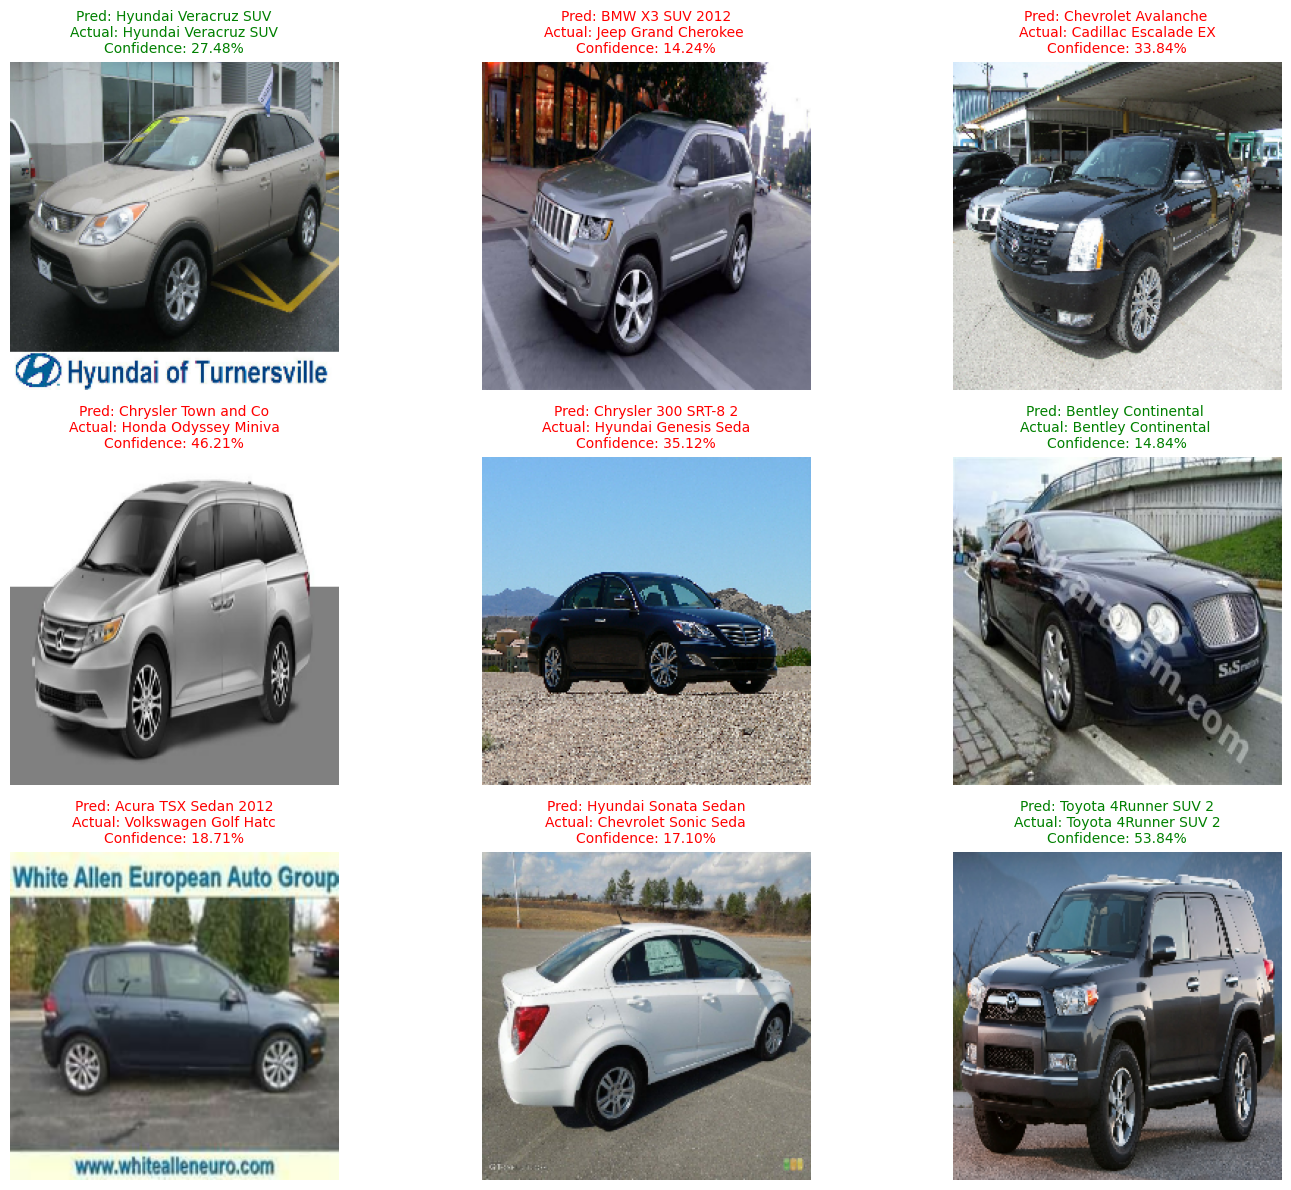

In [10]:
def visualize_tl_predictions(model, dataset, class_names, num_images=9):
    plt.figure(figsize=(15, 12))

    # Get one batch from the validation dataset
    for images, labels in dataset.take(1):
        # Generate predictions
        predictions = model.predict(images)

        for i in range(min(num_images, len(images))):
            plt.subplot(3, 3, i + 1)

            # Pre-trained models often use normalized floats;
            # we cast back to uint8 for plotting if necessary
            img = images[i].numpy()
            if img.max() <= 1.0: # If normalized to [0,1]
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            plt.imshow(img)

            # Find prediction info
            predicted_idx = np.argmax(predictions[i])
            probability = np.max(predictions[i]) * 100
            actual_idx = labels[i].numpy()

            # Formatting titles
            title_color = "green" if predicted_idx == actual_idx else "red"
            plt.title(
                f"Pred: {class_names[predicted_idx][:20]}\n"
                f"Actual: {class_names[actual_idx][:20]}\n"
                f"Confidence: {probability:.2f}%",
                color=title_color, fontsize=10
            )
            plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_tl_predictions(tl_model, val_ds, class_names)

### Identifying "Confused" Classes (Heatmap)
In a fine-grained dataset with 196 classes, a Confusion Matrix is essential. However, because 196x196 is too large to read, it's better to visualize the top-k classes where the model is struggling.

In [11]:
from sklearn.metrics import classification_report
import numpy as np

# 1. Collect a larger sample to get better results
y_true = []
y_pred = []

# Using more batches (e.g., 20) ensures a better variety of cars
for images, labels in val_ds.take(20):
    preds = tl_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Convert class_names to a list if it's not already
target_names = list(class_names)

# 3. FIX: Pass the 'labels' parameter to match the IDs with the names
# range(len(target_names)) creates a list [0, 1, 2, ..., 195]
print(classification_report(
    y_true,
    y_pred,
    labels=range(len(target_names)),
    target_names=target_names,
    zero_division=0 # This prevents warnings for classes with 0 samples
))

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.80      1.00      0.89         4
                             Acura Integra Type R 2001       0.50      0.50      0.50         6
                                   Acura RL Sedan 2012       0.00      0.00      0.00         4
                                   Acura TL Sedan 2012       0.00      0.00      0.00         2
                                  Acura TL Type-S 2008       0.00      0.00      0.00         3
                                  Acura TSX Sedan 2012       0.40      0.67      0.50         3
                              Acura ZDX Hatchback 2012       0.40      0.67      0.50         3
              Aston Martin V8 Vantage Convertible 2012       0.09      1.00      0.17         1
                    Aston Martin V8 Vantage Coupe 2012       0.33      0.33      0.33         3
                  Aston Martin Virage C

## Conclusion

Transfer Learning is the industry standard for fine-grained classification. By leveraging the MobileNetV2 architecture, we benefit from a model that is both lightweight for CPU usage and deep enough to capture complex automotive features. While a custom CNN might struggle to reach 50% accuracy on 196 car classes, a pre-trained model provides a sophisticated "visual vocabulary" that dramatically accelerates convergence and boosts final accuracy into the 80–95% range.